In [1]:
%cd ~/github/agn_lf/
import source.astro_functions as af
import source.table_functions as tf
import source.lf_xi2 as xi2
import source.vmax as vmax
import source.utils as utils
import source.selection_criteria as sc
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.table as table
import astropy.units as u

from sklearn.neighbors import KernelDensity
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

utils.configure_plot_params()

/Users/runburg/github/agn_lf


In [2]:
#Frome line 4_HELP:

# catalog = table.Table.read('./data/master_cat_irac3_mips24')
catalog = table.Table.read('./data/help_full_catalog_with_fluxes_and_redshifts.fits')
print(len(catalog))
#catalog[0]

18328


Okay so first step is to only select the objects within the colorwedge shown below. This chooses IR sources based on their location in color space. These wedges are chosen to select AGN while trying to avoid non-AGN IR sources.

5918 selected AGN


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


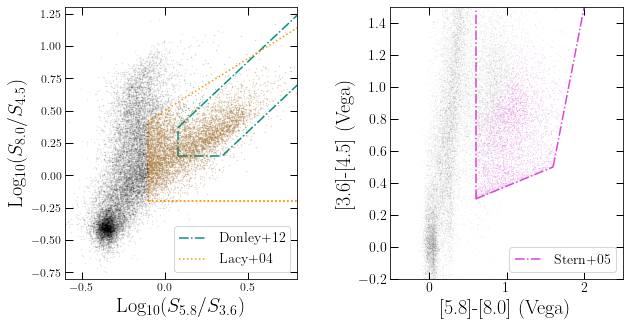

In [3]:
#From line 6_HELP:

flux36 = 'f_ap_irac_i1'
flux45 = 'f_ap_irac_i2'
flux58 = 'f_ap_irac_i3'
flux80 = 'f_ap_irac_i4'
flux240 = 'f_mips_24'
# print(catalog[flux58][catalog[flux58] < 0])
never_nan = (np.nan_to_num(catalog[flux58], nan=-99) > 0) & (np.nan_to_num(catalog[flux80], nan=-99) > 0) #& (np.nan_to_num(catalog['zspec'], nan=-99) > 0)
fig, axs = sc.plot_wedge(catalog[never_nan], flux36, flux45, flux58, flux80, selection=['lacy05', 'stern05', 'donley12'])
selected_agn = sc.select_ir(catalog[never_nan], flux36, flux45, flux58, flux80, selection_cuts='lacy05')
print(np.sum(selected_agn), 'selected AGN')

In [4]:
#From line 7-8_HELP:

utils.configure_plot_params()
print(np.sum(never_nan), np.sum(selected_agn))
ct_lacy = catalog[never_nan][selected_agn]
np.sum(ct_lacy[flux240] > 0) / 6014

18328 5918


0.9840372464250083

We want to select our redshifts for each object. We prioritize spectroscopic redshifts, but default to photometric when specz are unavailable.

We also calculate the luminosity. L=4pi F^2, but remember we are using flux densitiy, so we need to convert and make units workout (hence, unit_conversion). The spectral index accounts for the shape of the SED(Spectral Energy Distribution: energy emitted at a certain wavelength). If the object is radiating differently in different wavelengths, the spectral index allows us to adjust the luminosity in order to account for this.

In [5]:
#From Line 9_HELP:

cosmo = af.setup_cosmology()
print('selected_agn:', len(ct_lacy))

ct_lacy = ct_lacy[(ct_lacy['redshift'] > 0 ) | (ct_lacy['zspec'] > 0)]
# ct_lacy = ct_lacy[ct_lacy['z_eazy'] > 0]
print('selected agn with z:', len(ct_lacy))

# unit conversion: ujansky -> jansky: 1e-6
# jansky -> erg / s / cm**2 / Hz: 1e-23
# erg / s / Hz -> erg / s: nu = c/lambda = 3e8 / 3.6e-6
# unit_conversion = 1e-6 * 1e-23 * 3e8 / 3.6e-6 * (3.086e24)**2
wavelength = 5.8
unit_conversion = 3 / wavelength * 1e-15
# print(unit_conversion)

unbias_photoz = 0.0
z = np.array([row['zspec'] if row['zspec'] > 0 else row['redshift'] - unbias_photoz for row in ct_lacy])
# z = np.array([row['z1_median'] - unbias_photoz for row in ct_lacy])
#print(min(z))

#z[z <= 0] = 0
# z = ct_lacy['z_eazy']

spectral_index = np.log10(ct_lacy[flux240].data/ct_lacy[flux58].data) / np.log10(24/5.8)
# spectral_index[spectral_index < -4] = -2
# spectral_index = np.array([0])
print('spectral index min:', spectral_index.min())
print('spectral index max:', spectral_index.max())

bolo_corr = 1

l = 4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2 * ct_lacy[flux58].data * unit_conversion * (1 + z)**(-1 + spectral_index) * bolo_corr

selected_agn: 5918
selected agn with z: 5918
spectral index min: -3.4994921634885165
spectral index max: 2.928229538765928


In [6]:
#From line 2_xservs:

xservs_catalog = table.Table.read('./data/tableA.v01.fits')
# xservs_catalog.columns
print(len(xservs_catalog))
xservs_catalog[0]

5242


XID,RA,DEC,XPOSERR,R68,R99,EMLERR,SB_RA,SB_DEC,HB_RA,HB_DEC,FB_RA,FB_DEC,SB_DET_ML,HB_DET_ML,FB_DET_ML,SB_RELIABILITY,HB_RELIABILITY,FB_RELIABILITY,SB_EXP,HB_EXP,FB_EXP,SB_EXPPN,SB_EXPM1,SB_EXPM2,HB_EXPPN,HB_EXPM1,HB_EXPM2,FB_EXPPN,FB_EXPM1,FB_EXPM2,SB_BKG,HB_BKG,FB_BKG,SB_BKGPN,SB_BKGM1,SB_BKGM2,HB_BKGPN,HB_BKGM1,HB_BKGM2,FB_BKGPN,FB_BKGM1,FB_BKGM2,SB_SCTS,HB_SCTS,FB_SCTS,SB_SCTPN,SB_SCTM1,SB_SCTM2,HB_SCTPN,HB_SCTM1,HB_SCTM2,FB_SCTPN,FB_SCTM1,FB_SCTM2,SB_SCTS_ERR,HB_SCTS_ERR,FB_SCTS_ERR,SB_SCTPN_ERR,SB_SCTM1_ERR,SB_SCTM2_ERR,HB_SCTPN_ERR,HB_SCTM1_ERR,HB_SCTM2_ERR,FB_SCTPN_ERR,FB_SCTM1_ERR,FB_SCTM2_ERR,SB_RATE,SB_RATEPN,SB_RATEM1,SB_RATEM2,HB_RATE,HB_RATEPN,HB_RATEM1,HB_RATEM2,FB_RATE,FB_RATEPN,FB_RATEM1,FB_RATEM2,SB_RATE_ERR,SB_RATEPN_ERR,SB_RATEM1_ERR,SB_RATEM2_ERR,HB_RATE_ERR,HB_RATEPN_ERR,HB_RATEM1_ERR,HB_RATEM2_ERR,FB_RATE_ERR,FB_RATEPN_ERR,FB_RATEM1_ERR,FB_RATEM2_ERR,SB_FLUX,SB_FLUXERR,HB_FLUX,HB_FLUXERR,FB_FLUX,FB_FLUXERR,HR,HR_LERR,HR_UERR,BEHR_PN,BEHR_LB_PN,BEHR_UB_PN,BEHR_M1,BEHR_LB_M1,BEHR_UB_M1,BEHR_M2,BEHR_LB_M2,BEHR_UB_M2,LX,CSCID,XXLID,NALL_SERVS,NALL_VIDEO,NALL_CFHT,NALL_HSC,NMATCH_LR_SERVS,NMATCH_LR_VIDEO,NMATCH_LR_CFHT,NMATCH_LR_HSC,LR_RELIABLE,SERVS_BLENDING,CATALOG,OIR_RA,OIR_DEC,XOIR_SEP,LR,SERVS_RA,SERVS_DEC,SERVS_ID,SERVS_MR,VIDEO_RA,VIDEO_DEC,VIDEO_ID,VIDEO_MR,CFHT_RA,CFHT_DEC,CFHT_ID,CFHT_MR,HSC_RA,HSC_DEC,HSC_ID,HSC_MR,SERVS_MAG1,SERVS_MAG2,SERVS_MAG1_ERR,SERVS_MAG2_ERR,SWIRE_MAG1,SWIRE_MAG2,SWIRE_MAG3,SWIRE_MAG4,SWIRE_MAG1_ERR,SWIRE_MAG2_ERR,SWIRE_MAG3_ERR,SWIRE_MAG4_ERR,SWIRE_MIPS24,SWIRE_MIPS24_ERR,VIDEO_ZMAG,VIDEO_ZMAGERR,VIDEO_YMAG,VIDEO_YMAGERR,VIDEO_JMAG,VIDEO_JMAGERR,VIDEO_HMAG,VIDEO_HMAGERR,VIDEO_KSMAG,VIDEO_KSMAGERR,CFHT_UMAG,CFHT_UMAGERR,CFHT_GMAG,CFHT_GMAGERR,CFHT_RMAG,CFHT_RMAGERR,CFHT_IMAG,CFHT_IMAGERR,CFHT_ZMAG,CFHT_ZMAGERR,HSC_GMAG,HSC_GMAGERR,HSC_RMAG,HSC_RMAGERR,HSC_IMAG,HSC_IMAGERR,HSC_ZMAG,HSC_ZMAGERR,HSC_YMAG,HSC_YMAGERR,ZSPEC_RA,ZSPEC_DEC,ZSPEC_ID,ZSPEC,ZSOURCE,ZOFLAG,ZPHOT,ZPHOT_UERR,ZPHOT_LERR,ZPHOT_QZ,CLASS,SECONDARY_CATALOG,SECONDARY_RA,SECONDARY_DEC,SECONDARY_SEP,SECONDARY_LR,SECONDARY_SERVS_RA,SECONDARY_SERVS_DEC,SECONDARY_SERVS_ID,SECONDARY_SERVS_MR,SECONDARY_VIDEO_RA,SECONDARY_VIDEO_DEC,SECONDARY_VIDEO_ID,SECONDARY_VIDEO_MR,SECONDARY_CFHT_RA,SECONDARY_CFHT_DEC,SECONDARY_CFHT_ID,SECONDARY_CFHT_MR,SECONDARY_HSC_RA,SECONDARY_HSC_DEC,SECONDARY_HSC_ID,SECONDARY_HSC_MR,SECONDARY_SERVS_MAG1,SECONDARY_SERVS_MAG2,SECONDARY_SERVS_MAG1_ERR,SECONDARY_SERVS_MAG2_ERR,SECONDARY_SWIRE_MAG1,SECONDARY_SWIRE_MAG2,SECONDARY_SWIRE_MAG3,SECONDARY_SWIRE_MAG4,SECONDARY_SWIRE_MAG1_ERR,SECONDARY_SWIRE_MAG2_ERR,SECONDARY_SWIRE_MAG3_ERR,SECONDARY_SWIRE_MAG4_ERR,SECONDARY_SWIRE_MIPS24,SECONDARY_SWIRE_MIPS24_ERR,SECONDARY_VIDEO_ZMAG,SECONDARY_VIDEO_ZMAGERR,SECONDARY_VIDEO_YMAG,SECONDARY_VIDEO_YMAGERR,SECONDARY_VIDEO_JMAG,SECONDARY_VIDEO_JMAGERR,SECONDARY_VIDEO_HMAG,SECONDARY_VIDEO_HMAGERR,SECONDARY_VIDEO_KSMAG,SECONDARY_VIDEO_KSMAGERR,SECONDARY_CFHT_UMAG,SECONDARY_CFHT_UMAGERR,SECONDARY_CFHT_GMAG,SECONDARY_CFHT_GMAGERR,SECONDARY_CFHT_RMAG,SECONDARY_CFHT_RMAGERR,SECONDARY_CFHT_IMAG,SECONDARY_CFHT_IMAGERR,SECONDARY_CFHT_ZMAG,SECONDARY_CFHT_ZMAGERR,SECONDARY_HSC_GMAG,SECONDARY_HSC_GMAGERR,SECONDARY_HSC_RMAG,SECONDARY_HSC_RMAGERR,SECONDARY_HSC_IMAG,SECONDARY_HSC_IMAGERR,SECONDARY_HSC_ZMAG,SECONDARY_HSC_ZMAGERR,SECONDARY_HSC_YMAG,SECONDARY_HSC_YMAGERR,SECONDARY_ZSPEC_RA,SECONDARY_ZSPEC_DEC,SECONDARY_ZSPEC_ID,SECONDARY_ZSPEC,SECONDARY_ZSOURCE,SECONDARY_ZOFLAG,TERTIARY_CATALOG,TERTIARY_RA,TERTIARY_DEC,TERTIARY_SEP,TERTIARY_LR,TERTIARY_SERVS_RA,TERTIARY_SERVS_DEC,TERTIARY_SERVS_ID,TERTIARY_SERVS_MR,TERTIARY_VIDEO_RA,TERTIARY_VIDEO_DEC,TERTIARY_VIDEO_ID,TERTIARY_VIDEO_MR,TERTIARY_CFHT_RA,TERTIARY_CFHT_DEC,TERTIARY_CFHT_ID,TERTIARY_CFHT_MR,TERTIARY_HSC_RA,TERTIARY_HSC_DEC,TERTIARY_HSC_ID,TERTIARY_HSC_MR,TERTIARY_SERVS_MAG1,TERTIARY_SERVS_MAG2,TERTIARY_SERVS_MAG1_ERR,TERTIARY_SERVS_MAG2_ERR,TERTIARY_SWIRE_MAG1,TERTIARY_SWIRE_MAG2,TERTIARY_SWIRE_MAG3,TERTIARY_SWIRE_MAG4,TERTIARY_SWIRE_MAG1_ERR,TERTIARY_SWIRE_MAG2

In [7]:
#From line 7_xservs:

cosmo = af.setup_cosmology()
print('objects in full catalog:',len(xservs_catalog))

xservs_catalog = xservs_catalog[(xservs_catalog['ZPHOT'] > 0 ) | (xservs_catalog['ZSPEC'] > 0)]
print('objects working with from catalog:', len(xservs_catalog))

import astropy.units as u

spectral_index = np.log10(xservs_catalog['HB_FLUX'].data/xservs_catalog['SB_FLUX'].data) / np.log10(6/1.25)
# spectral_index = 1.7
print(spectral_index)
xray_z = np.array([row['ZSPEC'] if row['ZSPEC'] > 0 else row['ZPHOT'] for row in xservs_catalog])
xray_l = 4 * np.pi * cosmo.luminosity_distance(xray_z).to(u.cm).value**2 * xservs_catalog['FB_FLUX'] * (1 + xray_z)**(-1 + spectral_index)

objects in full catalog: 5242
objects working with from catalog: 4505
[0.85557853 1.02608575 1.16422852 ... 1.1263865  0.25891391 1.22097932]


In [8]:
#From line 9_xservs:

z_sample_min = 0.5
z_sample_max = 4
l_sample_min = 3e42
l_sample_max = 3e45
num_bins_z = 10
num_bins_l = 15

# compare to ir
z_sample_min = 0.5
z_sample_max = 4
l_sample_min = 3e42
l_sample_max = 3e46
num_bins_z = 10
num_bins_l = 15




5918
[0.5        0.62996052 0.79370053 1.         1.25992105 1.58740105
 2.         2.5198421  3.1748021  4.        ]


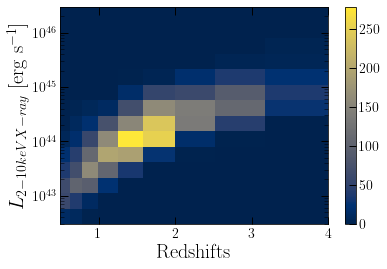

In [9]:
#From line 10_xservs:

# good_redshift_and_l_selected = (l_sample_min < xray_l) & (l_sample_max > xray_l) & (z_sample_min < xray_z) & (z_sample_max > xray_z)
# xray_l = xray_l[good_redshift_and_l_selected]
# xray_z = xray_z[good_redshift_and_l_selected]
print(len(z))
# redshift range 
z_bins = np.logspace(np.log10(z_sample_min), np.log10(z_sample_max), num=num_bins_z)
print(z_bins)
l_bins = np.logspace(np.log10(l_sample_min), np.log10(l_sample_max), num=num_bins_l)

# print(len(z))
fig, ax, histo = vmax.l_z_histo(xray_l, xray_z, l_bins, z_bins, band='2-10 keV X-ray', unit=r'erg s$^{-1}$')

In [10]:
print(histo)
print(histo.min(), histo.max())

[[ 14.  60.  65.  38.  21.   7.   1.   0.   1.   0.   0.   0.   0.   0.]
 [ 10.  40. 104.  69.  44.  19.  10.   4.   1.   1.   0.   0.   0.   0.]
 [  2.  12.  95. 160. 109.  58.  21.   8.   1.   1.   0.   0.   0.   0.]
 [  0.   0.  24. 107. 197. 160.  74.  13.   0.   0.   1.   0.   0.   0.]
 [  0.   0.   1.  34. 192. 278. 155.  69.  17.   2.   0.   0.   0.   0.]
 [  0.   0.   0.   1.  27. 253. 239. 160.  55.   5.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   2.  18. 137. 140.  61.  20.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   2.  44. 109.  92.  38.   5.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   1.  28.  38.  24.   6.   4.   0.   0.]]
0.0 278.0


Text(0.5, 0, 'Redshift')

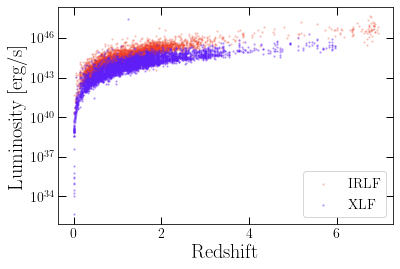

In [11]:
fig, axs = plt.subplots()
axs.set_yscale('log')
axs.scatter(z, l, s=2, alpha=0.2, color='xkcd:tomato', label='IRLF') #alpha = transparency #s = size of data points
axs.scatter(xray_z, xray_l, s=2, alpha=0.3, color='xkcd:purplish blue', label='XLF')
axs.legend()
axs.set_ylabel('Luminosity [erg/s]')
axs.set_xlabel('Redshift')

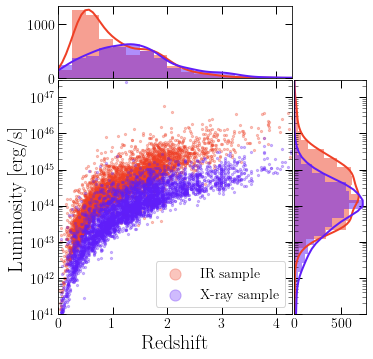

In [12]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, label='IRLF', scatter_color='xkcd:tomato'):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    

    # the scatter plot:
    ax.scatter(x, y, s=5, alpha=0.3,  label=label, color=scatter_color)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    xbins = np.arange(0, x.max(), binwidth)
    #ybins = np.logspace(np.log10(y.min()), np.log10(y.max()), num=30)
    ybins = 10**np.arange(np.log10(y.min()), np.log10(y.max()), binwidth)
    xhist = ax_histx.hist(x, bins=xbins, color=scatter_color, alpha=0.5)
    yhist = ax_histy.hist(y, bins=ybins, orientation='horizontal', color=scatter_color, alpha=0.5)
    
    # redshift kde
    kde = KernelDensity(bandwidth=0.2, kernel='gaussian')
    kde.fit(x[:, None])
    kdexbins = np.linspace(0, x.max(), num=100)
    logprob = kde.score_samples(kdexbins[:, None])
    ax_histx.plot(kdexbins, np.exp(logprob) * xhist[0].max() / np.exp(logprob).max(), lw=2, color=scatter_color)
#     ax_histx2 = ax_histx.twinx()
#     ax_histx2.plot(kdexbins, np.exp(logprob), lw=2, color=scatter_color)
#     ax_histx2.set_yscale('log')
#     print(np.exp(logprob))
    
    # lum kde
    kde.fit(np.log10(y[:, None]))
    kdexbins = np.linspace(np.log10(y.min()), np.log10(y.max()), num=100)
    logprob = kde.score_samples(kdexbins[:, None])
#     print(np.exp(logprob)/np.exp(logprob).max())
#     print(logprob)
    ax_histy.plot(np.exp(logprob) * yhist[0].max() / np.exp(logprob).max(), 10**kdexbins, lw=2, color=scatter_color)
 
    
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(5, 5))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(z, l, ax, ax_histx, ax_histy, label="IR sample", scatter_color='xkcd:tomato') 
scatter_hist(xray_z, xray_l, ax, ax_histx, ax_histy, label="X-ray sample", scatter_color='xkcd:purplish blue') 

ax.set_yscale('log')
ax.legend(markerscale=5)
ax.set_ylabel('Luminosity [erg/s]')
ax.set_xlabel('Redshift')
ax.set_ylim(top=3e47, bottom=1e41) #set limits = ax.set_ylim(top=number, bottom=number)
ax.set_xlim(left=0, right=4.3)           #set limits = ax.set_xlim(left=number, right=number)

fig.savefig('./output/paper_plots/lum_vs_red.pdf', bbox_inches='tight')






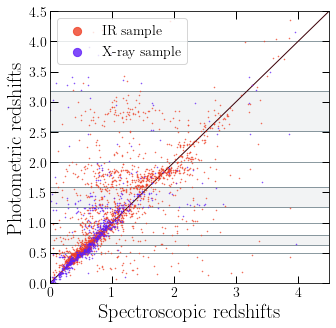

In [13]:
goodzs = (ct_lacy['redshift'] > 0) & (ct_lacy['zspec'] > 0)
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(ct_lacy['zspec'][goodzs], ct_lacy['redshift'][goodzs], alpha=0.8, s=.3, color='xkcd:tomato', marker='o', label='IR sample')

ax.set_xlabel('Spectroscopic redshifts')
ax.set_ylabel('Photometric redshifts')
# ax.set_title('IR')
ax.set_ylim(top=4.5, bottom=0)
ax.set_xlim(left=0, right=4.5)
ax.plot([0, 5],[0,5], color='xkcd:dark maroon', zorder=-100, lw=1)
# ax.plot([0, 4],[0.4,4.4], color='r', ls='--')
# ax.plot([0, 4],[-.4,3.6], color='r', ls='--')

gray = 'xkcd:steel gray'
color_bins = [1, 4, 7]
for zbin in z_bins:
    ax.axhline(zbin, color=gray, alpha=0.8, zorder=-200, lw=1)

for i in color_bins:
    ax.fill_between([0,  4.5], [z_bins[i]]*2, [z_bins[i+1]]*2, color=gray, alpha=0.09, zorder=-300)

xgoodzs = (xservs_catalog['ZPHOT'] > 0) & (xservs_catalog['ZSPEC'] > 0)
ax.scatter(xservs_catalog['ZSPEC'][xgoodzs], xservs_catalog['ZPHOT'][xgoodzs], color='xkcd:purplish blue', alpha=0.8, s=.3, marker='o', label='X-ray sample')
ax.legend(markerscale=15, loc='upper left')



fig.savefig('./output/paper_plots/photo_vs_specz.pdf')
fig.savefig('./output/paper_plots/photo_vs_specz.svg')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


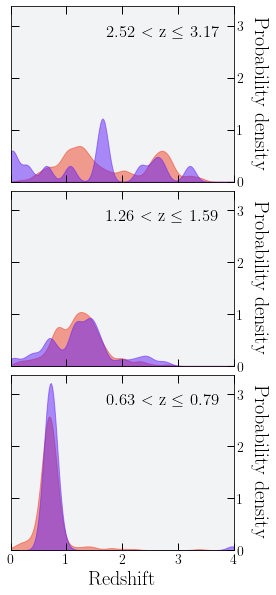

In [14]:
from sklearn.neighbors import KernelDensity
import matplotlib

fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(4, 10), sharey=True, sharex=True, gridspec_kw={'wspace': 0.1, 'hspace':0.05})

locs = np.linspace(0, z_bins[-1], num=200)
# for i in range(len(z_bins)-1):
for j, i in enumerate(reversed(color_bins)):
    inbin1 = (ct_lacy['redshift'][goodzs] > z_bins[i]) & (ct_lacy['redshift'][goodzs] < z_bins[i+1])
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(ct_lacy['zspec'][goodzs][inbin1][:, None])

    # score_samples returns the log of the probability density
    logprob = kde.score_samples(locs[:, None])

    axs.flatten()[j].fill_between(locs, np.exp(logprob), alpha=0.5, color='xkcd:tomato')
    
    inbin1 = (xservs_catalog['ZPHOT'][xgoodzs] > z_bins[i]) & (xservs_catalog['ZPHOT'][xgoodzs] < z_bins[i+1])
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(xservs_catalog['ZSPEC'][xgoodzs][inbin1][:, None])

    # score_samples returns the log of the probability density
    logprob = kde.score_samples(locs[:, None])

    axs.flatten()[j].fill_between(locs, np.exp(logprob), alpha=0.5, color='xkcd:purplish blue')
    
    axs.flatten()[j].plot([], [], label=rf'{round(z_bins[i], 2)} $<$ z $\leq$ {round(z_bins[i+1], 2)}')
    axs.flatten()[j].legend(markerscale=0, frameon=False, handlelength=0, handletextpad=0, fontsize='large')
#     axs.flatten()[j].set_ylim(bottom=0)
#     axs.flatten()[j].set_xlabel('Redshift')
    
    axs.flatten()[j].set_ylabel('Probability density', rotation=270, rotation_mode='anchor', labelpad=25, fontsize='x-large')
    axs.flatten()[j].yaxis.set_label_position('right')
    axs.flatten()[j].tick_params(labelleft=False, labelright=True)

axs.flatten()[-1].set_xlabel('Redshift')
    
for ax in axs:
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0, right=4)
    ax.set_facecolor(matplotlib.colors.to_rgba(gray, alpha=0.09))
    
fig.savefig('./output/paper_plots/redshift_kdes.pdf')
fig.savefig('./output/paper_plots/redshift_kdes.svg')